In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ionosphere_data.csv to ionosphere_data.csv


In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['ionosphere_data.csv']))

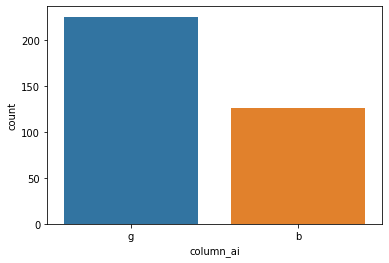

In [ ]:
sns.countplot(x='column_ai', data=df)

In [ ]:
df.rename(columns={'column_ai': 'label'}, inplace=True)
df['label'] = df.label.astype('category')
encoding = {'g': 1, 'b': 0}
df.label.replace(encoding, inplace=True)
df

,column_a,column_b,column_c,column_d,column_e,column_f,column_g,column_h,column_i,column_j,column_k,column_l,column_m,column_n,column_o,column_p,column_q,column_r,column_s,column_t,column_u,column_v,column_w,column_x,column_y,column_z,column_aa,column_ab,column_ac,column_ad,column_ae,column_af,column_ag,column_ah,label
0,True,False,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.00000,0.03760,0.85243,-0.17755,0.59755,-0.44945,0.60536,-0.38223,0.84356,-0.38542,0.58212,-0.32192,0.56971,-0.29674,0.36946,-0.47357,0.56811,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,1
1,True,False,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,0.50874,-0.67743,0.34432,-0.69707,-0.51685,-0.97515,0.05499,-0.62237,0.33109,-1.00000,-0.13151,-0.45300,-0.18056,-0.35734,-0.20332,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,0
2,True,False,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,0.73082,0.05346,0.85443,0.00827,0.54591,0.00299,0.83775,-0.13644,0.75535,-0.08540,0.70887,-0.27502,0.43385,-0.12062,0.57528,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,1
3,True,False,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-1.00000,0.14516,0.54094,-0.39330,-1.00000,-0.54467,-0.69975,1.00000,0.00000,0.00000,1.00000,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,0
4,True,False,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,0.52798,-0.20275,0.56409,-0.00712,0.34395,-0.27457,0.52940,-0.21780,0.45107,-0.17813,0.05982,-0.35575,0.02309,-0.52879,0.03286,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,True,False,0.83508,0.08298,0.73739,-0.14706,0.84349,-0.05567,0.90441,-0.04622,0.89391,0.13130,0.81197,0.06723,0.79307,-0.08929,1.00000,-0.02101,0.96639,0.06618,0.87605,0.01155,0.77521,0.06618,0.95378,-0.04202,0.83479,0.00123,1.00000,0.12815,0.86660,-0.10714,0.90546,-0.04307,1
347,True,False,0.95113,0.00419,0.95183,-0.02723,0.93438,-0.01920,0.94590,0.01606,0.96510,0.03281,0.94171,0.07330,0.94625,-0.01326,0.97173,0.00140,0.94834,0.06038,0.92670,0.08412,0.93124,0.10087,0.94520,0.01361,0.93522,0.04925,0.93159,0.08168,0.94066,-0.00035,0.91483,0.04712,1
348,True,False,0.94701,-0.00034,0.93207,-0.03227,0.95177,-0.03431,0.95584,0.02446,0.94124,0.01766,0.92595,0.04688,0.93954,-0.01461,0.94837,0.02004,0.93784,0.01393,0.91406,0.07677,0.89470,0.06148,0.93988,0.03193,0.92489,0.02542,0.92120,0.02242,0.92459,0.00442,0.92697,-0.00577,1
349,True,False,0.90608,-0.01657,0.98122,-0.01989,0.95691,-0.03646,0.85746,0.00110,0.89724,-0.03315,0.89061,-0.01436,0.90608,-0.04530,0.91381,-0.00884,0.80773,-0.12928,0.88729,0.01215,0.92155,-0.02320,0.91050,-0.02099,0.89147,-0.07760,0.82983,-0.17238,0.96022,-0.03757,0.87403,-0.16243,1


In [ ]:
df['column_a'] = df.column_a.astype('float64')

In [ ]:
X = df.values[:, :-1]
y = df.values[:, -1]

In [ ]:
from sklearn.model_selection import train_test_split
 
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7)

In [ ]:
from sklearn.preprocessing import StandardScaler
 
scaler = StandardScaler()
# The boolean feature does not need to be normalized.
x_train[:, 1:] = scaler.fit_transform(x_train[:, 1:])
x_test[:, 1:] = scaler.transform(x_test[:, 1:])

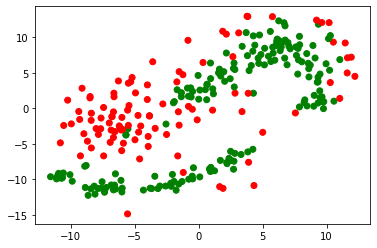

In [ ]:
from sklearn.manifold import TSNE
 
x_embedded = TSNE(n_components=2).fit_transform(x_train)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=['green' if label else 'red' for label in y_train])
plt.show()

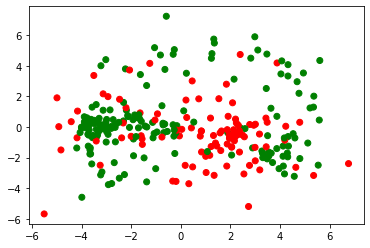

In [ ]:
from sklearn.decomposition import PCA
 
x_embedded = PCA(n_components=2).fit_transform(x_train)
plt.scatter(x_embedded[:, 0], x_embedded[:, 1], color=['green' if label else 'red' for label in y_train])
plt.show()

In [ ]:
iterations = 100
batch_size = 32

In [ ]:
from torch.utils.data import Dataset
 
 
class TrainData(Dataset):
    
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train
    
    def __getitem__(self, index):
        return self.x_train[index], self.y_train[index]
    
    def __len__ (self):
        return len(self.x_train)
 
    
class TestData(Dataset):
    
    def __init__(self, x_test):
        self.x_test = x_test
        
    def __getitem__(self, index):
        return self.x_test[index]
        
    def __len__ (self):
        return len(self.x_test)

In [ ]:
from torch.utils.data import DataLoader
 
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

NameError: ignored

In [ ]:
class Network(nn.Module):
    
    def __init__(self):
        super().__init__()
        # Number of input features is 33.
        self.linear_1 = nn.Linear(33, 64)
        self.linear_2 = nn.Linear(64, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(p=0.1)
    
    def forward(self, inputs):
        out = self.linear_1(inputs)
        out = F.relu(out)
        out = self.linear_2(out)
        out = F.relu(out)
        out = self.dropout(out)
        out = self.linear_3(out)
        # Sigmoid activation is later applied by the loss function for numerical stability.
        return out

In [ ]:
network = Network()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(network.parameters(), lr=1e-4)

In [ ]:
from sklearn.metrics import roc_auc_score
 
n_batches = len(train_loader)
 
network.train()
 
loss_li = []
score_li = []
 
for it in range(iterations):
    it_loss = 0
    it_score = 0
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_real = y_batch.unsqueeze(1)
        y_pred = network(x_batch)
        loss = criterion(y_pred, y_real)
        y_pred = torch.sigmoid(y_pred.detach())
        score = roc_auc_score(y_real, y_pred)
        loss.backward()
        optimizer.step()
        it_loss += loss.item()
        it_score += score
    loss_li.append(it_loss / n_batches)
    score_li.append(it_score / n_batches)
    print('[Iteration {}] Loss: {:.4f}, Area-Under-Curve: {:.4f}'.format(it, it_loss / n_batches, it_score / n_batches))

[Iteration 0] Loss: 0.6823, Area-Under-Curve: 0.6027
[Iteration 1] Loss: 0.6757, Area-Under-Curve: 0.7106
[Iteration 2] Loss: 0.6718, Area-Under-Curve: 0.7643
[Iteration 3] Loss: 0.6675, Area-Under-Curve: 0.8267
[Iteration 4] Loss: 0.6609, Area-Under-Curve: 0.8852
[Iteration 5] Loss: 0.6574, Area-Under-Curve: 0.8963
[Iteration 6] Loss: 0.6542, Area-Under-Curve: 0.8935
[Iteration 7] Loss: 0.6489, Area-Under-Curve: 0.9274
[Iteration 8] Loss: 0.6421, Area-Under-Curve: 0.9313
[Iteration 9] Loss: 0.6388, Area-Under-Curve: 0.9490
[Iteration 10] Loss: 0.6311, Area-Under-Curve: 0.9602
[Iteration 11] Loss: 0.6246, Area-Under-Curve: 0.9568
[Iteration 12] Loss: 0.6196, Area-Under-Curve: 0.9637
[Iteration 13] Loss: 0.6143, Area-Under-Curve: 0.9606
[Iteration 14] Loss: 0.6088, Area-Under-Curve: 0.9489
[Iteration 15] Loss: 0.6025, Area-Under-Curve: 0.9755
[Iteration 16] Loss: 0.5955, Area-Under-Curve: 0.9548
[Iteration 17] Loss: 0.5907, Area-Under-Curve: 0.9663
[Iteration 18] Loss: 0.5820, Area-Unde

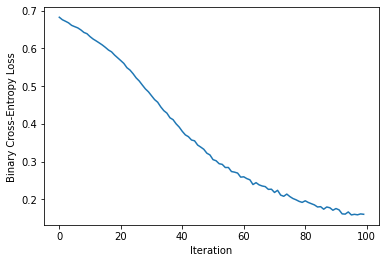

In [ ]:
plt.plot(loss_li)
plt.xlabel('Iteration')
plt.ylabel('Binary Cross-Entropy Loss')
plt.show()

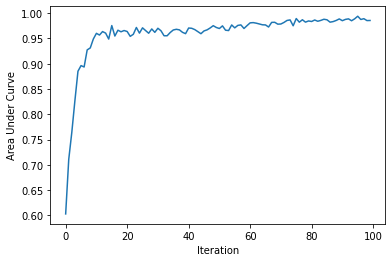

In [ ]:
plt.plot(score_li)
plt.xlabel('Iteration')
plt.ylabel('Area Under Curve')
plt.show()

In [ ]:
network.eval()
 
predictions = []
 
with torch.no_grad():
    for x_batch in test_loader:
        y_pred = network(x_batch)
        y_pred = torch.sigmoid(y_pred)
        predictions.append(y_pred.squeeze().tolist())
 
y_pred = np.round(predictions)

NameError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
 
confusion_matrix(y_test, y_pred)

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
 
classification_report(y_test, y_pred, output_dict=True)

{'0.0': {'f1-score': 0.888888888888889,
  'precision': 0.9090909090909091,
  'recall': 0.8695652173913043,
  'support': 23},
 '1.0': {'f1-score': 0.9484536082474228,
  'precision': 0.9387755102040817,
  'recall': 0.9583333333333334,
  'support': 48},
 'accuracy': 0.9295774647887324,
 'macro avg': {'f1-score': 0.9186712485681559,
  'precision': 0.9239332096474954,
  'recall': 0.9139492753623188,
  'support': 71},
 'weighted avg': {'f1-score': 0.9291579949340949,
  'precision': 0.9291593718153074,
  'recall': 0.9295774647887324,
  'support': 71}}